# 布林带

一般而言，股价的运动总是围绕某一价值中枢（如均线、成本线等）在一定的范围内变动，而布林线指标便是在这个基础上，引进了股价信道的概念。在BOLL指标的思想中，股价信道的宽窄会随着股价波动幅度的大小而变化，并且会随着股价的变化而自动调整。

### BOLL指标的计算方法

BOLL指标的计算是建立在移动平均线与标准差的基础之上的，分为上轨线、中轨线和下轨线，在三线的基础上还可以计算出布林信道的宽度，具体计算的公式如下：

中轨线：

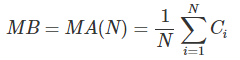

上轨线：

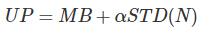

下轨线：

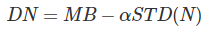

信道宽度：

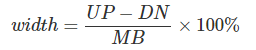

> - MB、UP、DN分别表示中轨线、上轨线与下轨线数值
> - width表示布林信道的宽度，以百分数表示
> - MA(N)表示的是N日的移动平均线
> - STD(N)表示的是N日的标准差
> - Ci表示的是第i日的收盘价
> - α是与置信程度相关的系数，默认为2

选股股票池：['000651.XSHE', '600036.XSHG', '000858.XSHE', '601398.XSHG'，000002.XSHE] 格力 招商银行 五粮液 工商银行 万科

策略 择时
1. 计算出20日的中轨线、上轨线与下轨线数值
2. 上轨线的系数α设置为2.59，下轨线的系数α设置为1.97
3. 对于股票池的每只股票，如果前2个close价格低于下轨线，而前一个价格close高于下轨线，则买入
4. 对于股票池的每只股票，如果前2个close价格高于上轨线，而前一个价格close低于上轨线，则平仓

止损:
1. 每日记录账户总资金
2. 设置账户总资金在大值变量g.peak_value
3. 如果账户总资金大于g.peak_value，更新g.peak_value
4. 如果当前账户总资金/初始总资金-g.peak_value/初始总资金<g.down (最高点的回撤达到30%，全部平仓，休息一段时间)
5. 休息时间为：g.peak_value/初始总资金 * g.beishu（设置的倍数），为何要这么设置？因为g.peak_value/初始总资金为收益百分比，只是百分比的话如果在0~1之间，乘以一个倍数，就是一个动态的平仓时间，如果为4~5倍，说明此收益已经很高了，大概率在牛市当中，如果遇见平仓条件，平仓时间为久一些

代码

In [ ]:
# 导入函数库
from jqdata	import *
import talib as	ta

# 初始化函数，设定基准等等
def	initialize(context):
	# 设定沪深300作为基准
	set_benchmark('000300.XSHG')
	# 开启动态复权模式(真实价格)
	set_option('use_real_price', True)
	total_value	= context.portfolio.total_value
	g.initial_value	= total_value
	g.peak_value = g.initial_value
	g.down = -0.30
	g.beishu = 30
    # g.time为达到平仓条件后，平仓的时间，这个事件与g.beishu有关
	g.time = 0
    # g.open为交易开关，0为交易状态，-1 为不交易状态
	g.open = 0
    # 记录不交易的天数
	g.days=0
	# 过滤掉order系列API产生的比error级别低的log
	# log.set_level('order', 'error')
	g.securities = ['000651.XSHE', '600036.XSHG', '000858.XSHE', '601398.XSHG','000002.XSHE'] #格力 招商银行 五粮液 工商银行	万科
	###	股票相关设定 ###
	# 股票类每笔交易时的手续费是：买入时佣金万分之三，卖出时佣金万分之三加千分之一印花税, 每笔交易佣金最低扣5块钱
	set_order_cost(OrderCost(close_tax=0.001, open_commission=0.0003, close_commission=0.0003, min_commission=5), type='stock')
	
	## 运行函数（reference_security为运行时间的参考标的；传入的标的只做种类区分，因此传入'000300.XSHG'或'510300.XSHG'是一样的）
	  #	开盘前运行
	run_daily(before_market_open, time='before_open', reference_security='000300.XSHG')	
	  #	开盘时或每分钟开始时运行
	run_daily(market_open, time='9:30',	reference_security='000300.XSHG')
	  #	收盘后运行
	run_daily(after_market_close, time='after_close', reference_security='000300.XSHG')
	
## 开盘前运行函数	   
def	before_market_open(context):
    pass
	
	
## 开盘时运行函数
def	market_open(context):
    # keys 为持仓的股票
	keys = context.portfolio.positions.keys()
	date = context.previous_date
	if g.open == -1:
		g.days = g.days+1
		if len(keys)!=0:
			for	i in keys:
                # 这一行是下单函数  i 是持仓中的某只股票，0 是让这只股票的市值为0，即全部卖出这只股票
				order_target_value(i,0)
	if g.days==g.time and g.time>0:
		g.open = 0
		g.days = 0
		g.time = 0
		total_value	= context.portfolio.total_value
#		g.initial_value	= total_value
		g.peak_value = total_value
	if g.open==0:
		for	i in g.securities:
			g.price	= get_price(i,end_date=date, frequency='daily',	fields='close',count=30)
            # g.price['upper'], g.price['middle'], g.price['lower']分别为布林带的上轨线、中轨线与下轨线数值
			g.price['upper'], g.price['middle'], g.price['lower'] =	ta.BBANDS(
					g.price.close.values,
					timeperiod=20,# 20日移动平均线，自己设置的
					# number of	non-biased standard	deviations from	the	mean
                    # 上轨和下轨的标准差倍数，改成这个数值因为这个数值更贴合，收益更好  
					nbdevup=2.33,
					nbdevdn=1.97,
					# Moving average type: simple moving average here
					matype=0)   # 0 是代表求简单移动平均线； 1 是代表加权移动平均线
			g.price	= g.price.dropna()
			# print(g.price.iloc[-2:])
			if g.price.iloc[-2]['close']>g.price.iloc[-2]['upper'] and g.price.iloc[-1]['close']<g.price.iloc[-1]['upper'] and i in	keys:
				order_target_value(i,0)
		
		
		
		cash = context.portfolio.available_cash
		keys = context.portfolio.positions.keys()
		num	= len(g.securities)-len(keys)
		# date = context.previous_date
		
        # 上面那一段根据信号卖，这一段是根据信号买，买和卖的函数要分开
		for	i in g.securities:
			g.price	= get_price(i,end_date=date, frequency='daily',	fields='close',count=30)
			g.price['upper'], g.price['middle'], g.price['lower'] =	ta.BBANDS(
					g.price.close.values,
					timeperiod=20,
					# number of	non-biased standard	deviations from	the	mean
					nbdevup=2.33,#2.33
					nbdevdn=1.97,
					# Moving average type: simple moving average here
					matype=0)
			g.price	= g.price.dropna()
			div_cash = cash/num
			# print(g.price.iloc[-2]['close'],g.price.iloc[-2]['lower'])
			if g.price.iloc[-2]['close']<g.price.iloc[-2]['lower'] and g.price.iloc[-1]['close']>g.price.iloc[-1]['lower'] and i not in	keys:
				order_target_value(i,div_cash)
	print(g.open)
	
 
## 收盘后运行函数	
def	after_market_close(context):
	total_value	= context.portfolio.total_value
	if total_value > g.peak_value:
		g.peak_value = total_value
	# if g.peak_value >	g.initial_value*1.5:
	if total_value/g.initial_value -(g.peak_value/g.initial_value) < g.down and g.open == 0:
		g.open = -1
		g.time = int((g.peak_value/g.initial_value)*g.beishu)
	print(total_value/g.initial_value -(g.peak_value/g.initial_value))
	print(g.time)


收益图

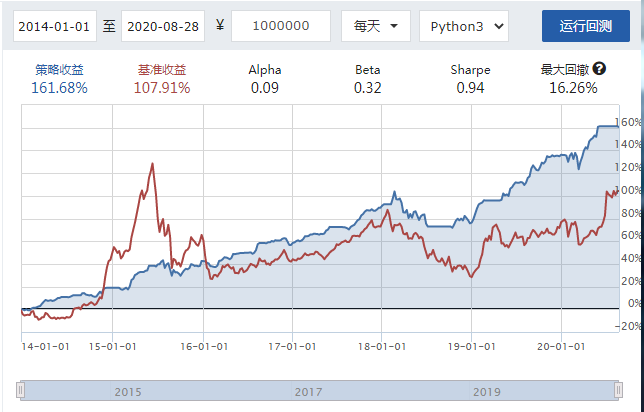